## General setup

In [1]:
%pip install torch torchvision torchaudio
%pip install ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/openai/CLIP.git to /private/var/folders/vf/zqlzjbwd7m78dmhj80bm10280000gn/T/pip-req-build-pdgvsu45
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/vf/zqlzjbwd7m78dmhj80bm10280000gn/T/pip-req-build-pdgvsu45
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
#to check if CLIP is successfully installed
import sys
import site
print("Python version:", sys.version)
print("\nPython path:")
for path in sys.path:
    print(path)

print("\nInstalled packages:")
import pkg_resources
for package in pkg_resources.working_set:
    if "clip" in package.key.lower():
        print(f"{package.key} - Version: {package.version}")

try:
    import clip
    print("\nCLIP import successful!")
    print("Available models:", clip.available_models())
except ImportError as e:
    print("\nFailed to import CLIP:", e)

Python version: 3.10.15 (main, Oct  3 2024, 02:33:33) [Clang 14.0.6 ]

Python path:
/Users/Laura/anaconda3/envs/cogs118b/lib/python310.zip
/Users/Laura/anaconda3/envs/cogs118b/lib/python3.10
/Users/Laura/anaconda3/envs/cogs118b/lib/python3.10/lib-dynload

/Users/Laura/anaconda3/envs/cogs118b/lib/python3.10/site-packages
/Users/Laura/anaconda3/envs/cogs118b/lib/python3.10/site-packages/setuptools/_vendor

Installed packages:
clip - Version: 1.0

CLIP import successful!
Available models: ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


## Imports

In [3]:
import torch
import clip
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision.datasets import CIFAR10
from torch.utils.data import Subset
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy

## Process CIFAR-10 dataset

Sample 100 images from CIFAR-10 (10 from each class)

In [12]:
def load_cifar10_samples(num_samples_per_class=10):
    dataset = CIFAR10(root='./data', train=True, download=True)
    
    # Get indices for each class
    class_indices = [[] for _ in range(10)]
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)
    
    # Randomly sample from each class
    selected_indices = []
    for class_idx in range(10):
        selected_indices.extend(random.sample(class_indices[class_idx], num_samples_per_class))
    
    # Shuffle the selected indices
    random.shuffle(selected_indices)
    
    return Subset(dataset, selected_indices)

Get CLIP embeddings for the sampled images

In [ ]:
def get_clip_embeddings(images):
    # Load the model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    print(f"Model loaded successfully on {device}")
    
    # Initialize array to store embeddings
    embeddings = []
    labels = []
    
    # Process each image
    for img, label in images:
        # Convert PIL image to RGB if needed
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Preprocess and get embedding
        image_input = preprocess(img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            image_features = model.encode_image(image_input)
            # Normalize the features
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            
        embeddings.append(image_features.cpu().numpy())
        labels.append(label)
    
    # Stack all embeddings into a single array
    embeddings = np.vstack(embeddings)
    labels = np.array(labels)
    
    return embeddings, labels

Actually run:

In [14]:
# Set random seed for reproducibility
random.seed(42)
torch.manual_seed(42)

# Load 10 images from each class (100 total)
cifar_samples = load_cifar10_samples(num_samples_per_class=10)

# Get embeddings
embeddings, labels = get_clip_embeddings(cifar_samples)

print(f"\nEmbeddings shape: {embeddings.shape}")
print(f"Labels shape: {labels.shape}")
print(f"First few values of first embedding: {embeddings[0, :5]}")
print(f"Distribution of classes: {np.bincount(labels)}")

Files already downloaded and verified
Model loaded successfully on cpu

Embeddings shape: (100, 512)
Labels shape: (100,)
First few values of first embedding: [ 0.01070201 -0.00073194 -0.02617841 -0.02562151  0.0150613 ]
Distribution of classes: [10 10 10 10 10 10 10 10 10 10]


## Now that we have the embeddings...

In [ ]:
def plot_similarity_matrices(embeddings, labels):
    # CIFAR-10 class names - used later for labeling the plots
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                  'dog', 'frog', 'horse', 'ship', 'truck']
    
    # Get label names
    label_names = [class_names[l] for l in labels]
    
    # Compute similarity matrix
    similarity_matrix = embeddings @ embeddings.T
    
    # Clustering
    
    # Cosine similarity ranges from -1 (very different) to 1 (very similar)
    # So by subtracting from 1, we now have distance from 0 (identical) to 2 (totally unrelated)
    distance_matrix = 1 - similarity_matrix 
    np.fill_diagonal(distance_matrix, 0) # Set diagonal to 0 because self-distance should be 0
    
    # For below: https://www.w3schools.com/python/python_ml_hierarchial_clustering.asp - "Ward" linkage is a type of hierarchical clustering
    # And: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html 
    linkage_matrix = hierarchy.linkage(squareform(distance_matrix), method='ward')
    
    # For below: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.leaves_list.html
    # This is so that we know how to reorder the labels
    clustering_order = hierarchy.leaves_list(linkage_matrix)
    
    # Create clustered version
    clustered_similarity = similarity_matrix[clustering_order][:, clustering_order]
    clustered_labels = [label_names[i] for i in clustering_order]
    
    # Create figure with two subplots (before and after clustering)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
    
    # Plot original similarity matrix
    sns.heatmap(similarity_matrix, 
                ax=ax1, 
                cmap='RdYlBu_r', 
                vmin=-1, 
                vmax=1,
                xticklabels=False,
                yticklabels=label_names,
                cbar_kws={'label': 'Similarity'})
    ax1.set_title('Original Similarity Matrix')
    ax1.tick_params(axis='y', rotation=0)
    
    # Plot clustered similarity matrix
    sns.heatmap(clustered_similarity, 
                ax=ax2, 
                cmap='RdYlBu_r', 
                vmin=-1, 
                vmax=1,
                xticklabels=False,
                yticklabels=clustered_labels,
                cbar_kws={'label': 'Similarity'})
    ax2.set_title('Clustered Similarity Matrix')
    ax2.tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.show()

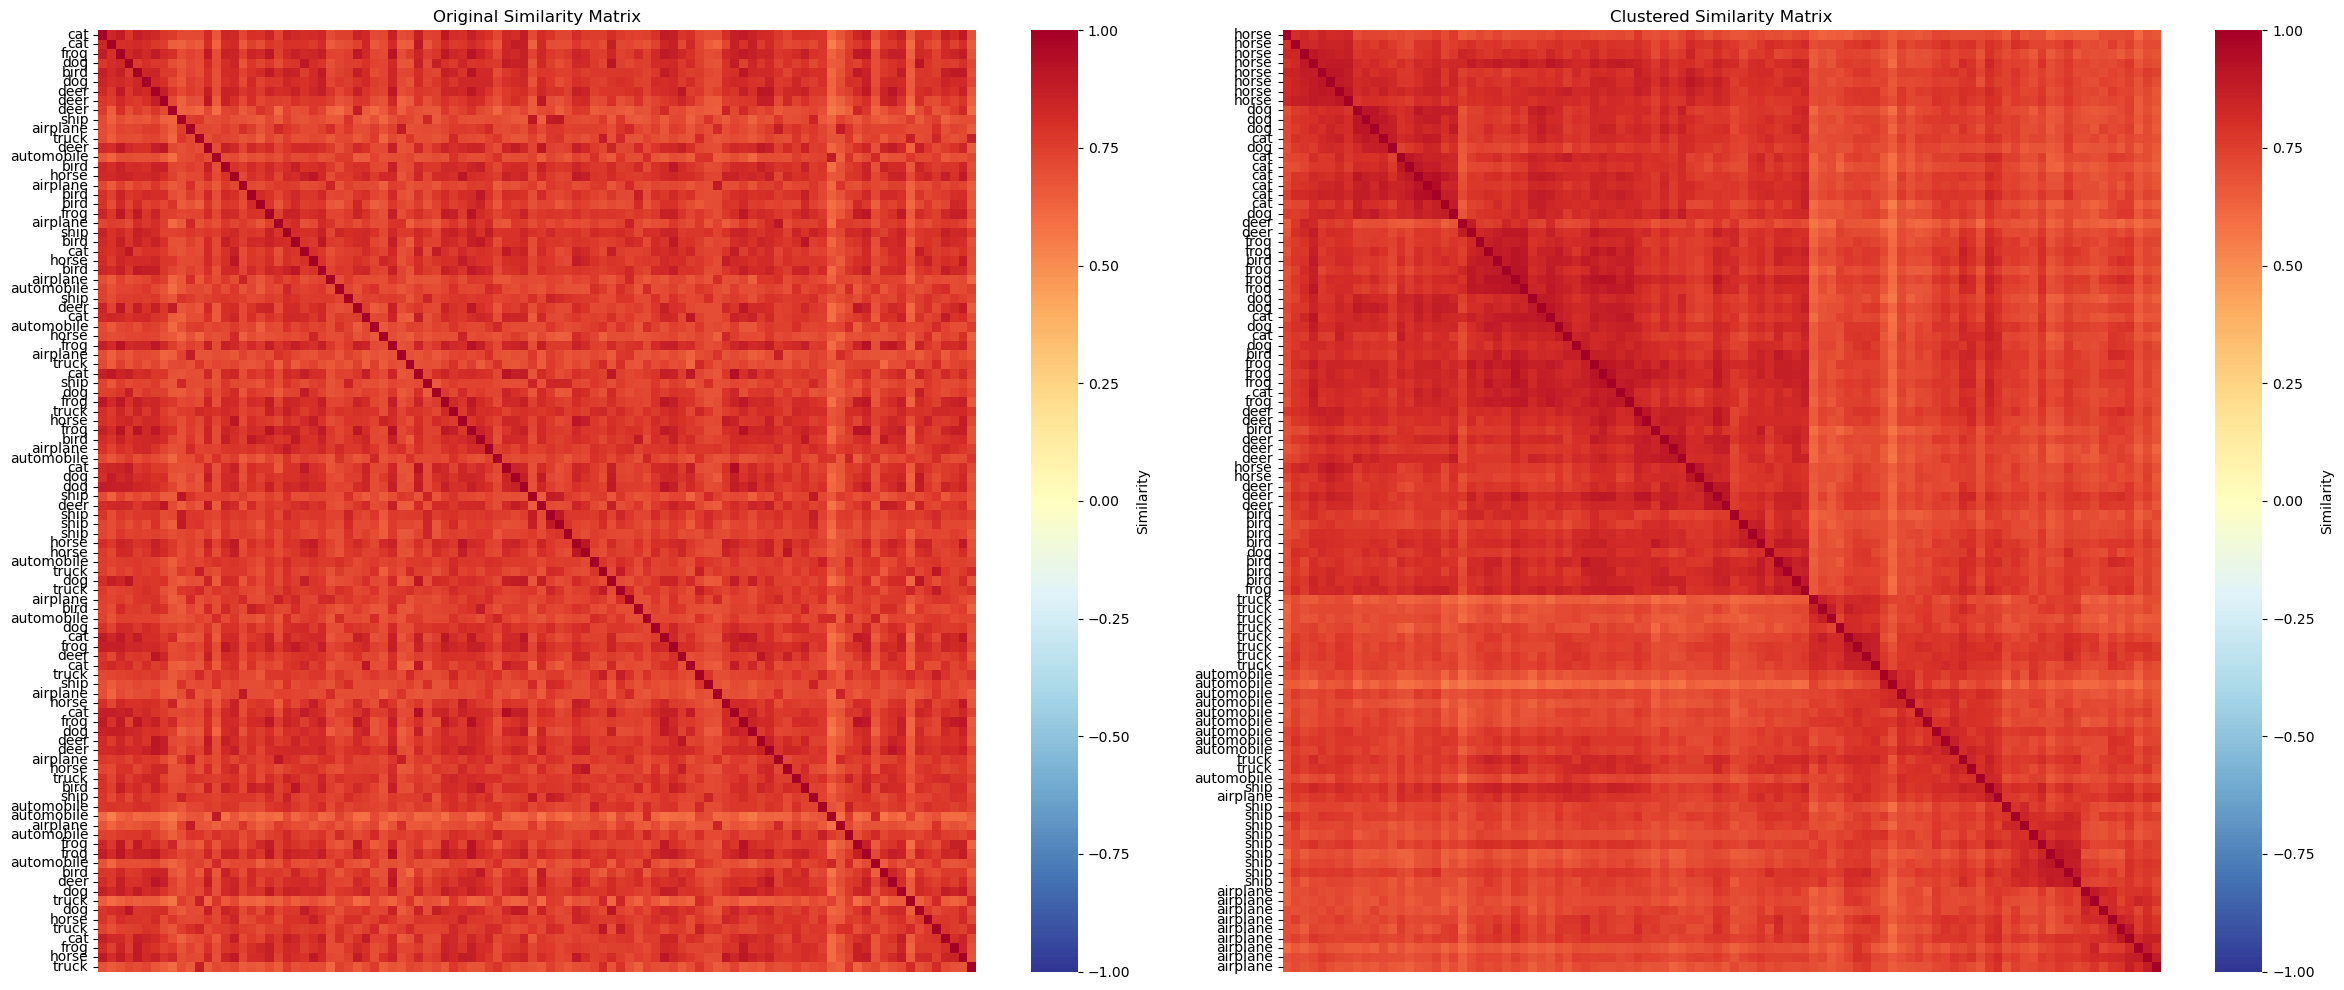

In [20]:
plot_similarity_matrices(embeddings, labels)

In the graphs above: 
- Left graph: Before performing hierarchical clustering. High similarity on the diagonal (since row i and column i are the same image).
- Right graph: After hierarchical clustering. There's a big "sub-square" at the top left - these are all animal labels, so this seems right. You can see smaller sub-squares near the diagonal, corresponding to the same classes.

Something still weird: Everything is super similar to each other (i.e., the whole graph is different shades of red). Why...?